# Task 2 – Analyzing UFO Sighting Descriptions (NLP)

This notebook performs NLP analysis on free-text descriptions of UFO sightings to uncover patterns in language, recurring keywords, and potential clusters.

### Steps:
- Text preprocessing (lowercasing, stopword removal, lemmatization)
- Vectorization using TF-IDF and CountVectorizer
- Word frequency analysis and day/night comparison
- Shape–color heatmap creation
- Sentence embedding and clustering with Sentence-BERT + KMeans

### Key Findings:
- Night sightings included more vague or color-related words (e.g., “light”, “object”, “orange”)
- Day reports were more shape-specific and detailed
- Clustering using sentence embeddings showed overlap and lacked distinct grouping across states

### Recommendations:
- Try better clustering methods (like topic modeling or UMAP) to group similar sightings more clearly.
- Analyze comments by year or area to find trends in how people describe events.
- Use keyword groups (like lights, movement, shape) to help understand and label the descriptions.







**Import and download**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import seaborn as sns
from collections import Counter


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**connect to drive and read the file**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using the table from task 1 after cleaning and adding columns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/full_ufo_dataset.csv', encoding='latin1')

<ipython-input-86-14c747f9fb60>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/full_ufo_dataset.csv', encoding='latin1')


**See the data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88873 entries, 0 to 88872
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              88873 non-null  object 
 1   city                  88677 non-null  object 
 2   state                 81355 non-null  object 
 3   country               76313 non-null  object 
 4   shape                 85755 non-null  object 
 5   duration (seconds)    88873 non-null  object 
 6   duration (hours/min)  85770 non-null  object 
 7   comments              88747 non-null  object 
 8   date posted           88873 non-null  object 
 9   latitude              88873 non-null  object 
 10  longitude             88873 non-null  float64
 11  Unnamed: 11           195 non-null    float64
 12  datetime_fixed        88873 non-null  object 
 13  duration_clean        88873 non-null  float64
 14  state/county          87650 non-null  object 
 15  year               

**Cleaning, Tokenization, Remove Stopwords and Lemmatization**

In order to extract meaningful insights from the textual comments in the dataset, we applied a standard NLP preprocessing pipeline consisting of the following steps:
1. Text Cleaning and Preprocessing

  In order to extract meaningful insights from the textual comments in the dataset, we applied a standard NLP preprocessing pipeline consisting of the following steps:

2. Text Normalization (Cleaning)

  All comments were converted to lowercase, and punctuation characters were removed using regular expressions.
  This ensures that variations such as "Light", "light!", and "LIGHT" are treated consistently.

3. Tokenization

  The cleaned sentences were split into individual words (tokens) using NLTK's word tokenizer.
  This transforms each sentence into a list of words, enabling word-level analysis and processing.

4. Stopword Removal

  Common English stopwords (e.g., "the", "and", "of") were removed using NLTK's stopword list.

5. Lemmatization

  Words were lemmatized using WordNetLemmatizer, which reduces them to their base or dictionary form (for example, "running" to "run", "cars" to "car").
  This allows different word forms with the same meaning to be treated as a single entity.

The resulting processed tokens were saved into two new columns:

1. tokens: a list format, used for models that expect input as lists of terms (for example, CountVectorizer).

2. tokens_str: a space-separated string version of the tokens, used for methods such as TF-IDF vectorization and embedding models like Sentence-BERT.


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stopwords = {'saw', 'seen', 'like', 'looked', 'said', 'just', 'think', 'thought'}
stop_words.update(custom_stopwords)

processed_comments = []

for sentence in df['comments']:
    if pd.isna(sentence):
        processed_comments.append([])
        continue
    # clean data
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Tokenization data
    words = nltk.word_tokenize(sentence)

    # Remove Stopwords
    lemmatized = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Lemmatization
    processed_comments.append(lemmatized)

# list Tokenization format
df['tokens'] = processed_comments

# string Tokenization format
df['tokens_str'] = df['tokens'].apply(lambda x: ' '.join(x))

## **Analysis products**

**Keywords and frequently repeated words in the comments column**

Vectorization

To convert the textual data into a numerical format suitable for analysis, we applied two classic vectorization techniques:

1. CountVectorizer: transforms each document into a vector representing the count of each word.
This is effective for understanding overall word frequency in the dataset.

2. TF-IDF (Term Frequency–Inverse Document Frequency): assigns weights to words based not only on frequency but also on how uniquely they appear across documents. It highlights terms that are both common and informative, and downweights those that are too ubiquitous.

Both vectorizers were applied to the entire comments column (after preprocessing), without additional filtering for identify dominant vocabulary themes across the full dataset.

In [ ]:
count_vectorizer = CountVectorizer(max_features=100)
X_count = count_vectorizer.fit_transform(df['tokens_str'])

tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(df['tokens_str'])

Textual Patterns and Visual Analysis of UFO Sightings

After applying vectorization (using both CountVectorizer and TF-IDF), i converted the resulting sparse matrices into DataFrames.
I then summed the counts (for CountVectorizer) and averaged the TF-IDF weights (for TfidfVectorizer), sorted the results and visualized the top 15 terms in each case using bar plots.

1. The first plot shows the most frequently used words across all sightings, based purely on raw occurrence.

2. The second plot highlights the most informative words as determined by the TF-IDF scoring, which accounts for both frequency and uniqueness across documents.

Key Insight:
Although many of the same words appear in both visualizations (e.g., light, object, sky, moving), some words have defferent rankings in the graphs due to how each method evaluates importance:

CountVectorizer emphasizes sheer frequency, giving higher rank to commonly used terms regardless of how widespread they are.

TF-IDF promotes terms that are not only frequent but also distinctive to specific comments — helping reveal more meaningful keywords for downstream analysis.

**Based on both vectorization methods (Count and TF-IDF), the top-ranked words fall into three meaningful categories:**

1. Colors – red, orange, white

  Often used to describe the appearance or glow of the sighted object.

2. Object Descriptions – object, craft, shaped, large, light

  These terms suggest how people attempt to categorize or describe the physical structure of the phenomenon.

3. Movement & Identification Verbs – moving, flying

  Common action words used in describing how the object was perceived in motion.

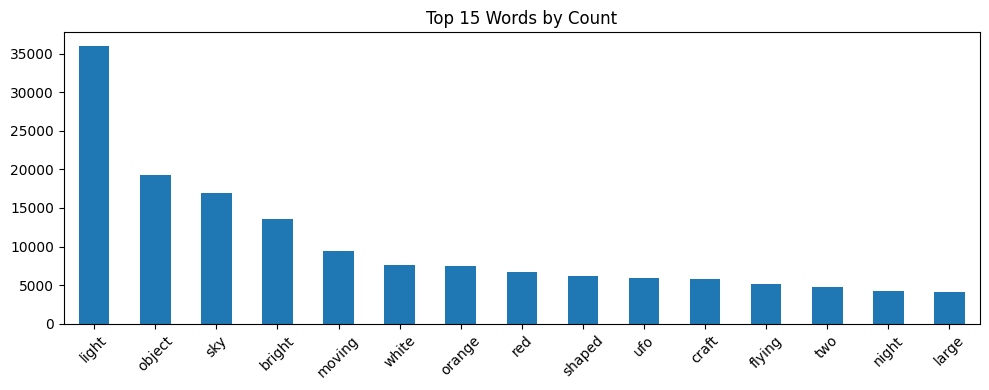

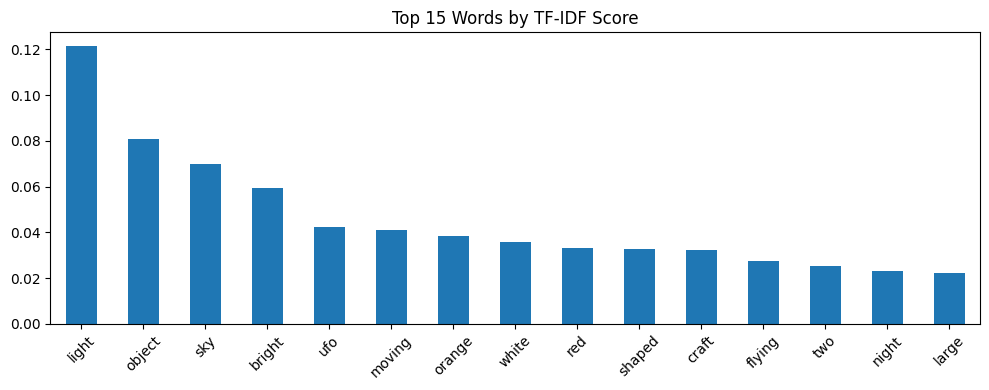

In [ ]:
count_df = pd.DataFrame(X_count.toarray(), columns=count_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

top_counts = count_df.sum().sort_values(ascending=False).head(15)
top_tfidf = tfidf_df.mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 4))
top_counts.plot(kind='bar', title='Top 15 Words by Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
top_tfidf.plot(kind='bar', title='Top 15 Words by TF-IDF Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Keywords and frequently repeated words by day time or night time**

Vectorization

At this stage, I wanted to examine whether there are differences in the language used to describe sightings that occurred during the day versus at night.
I split the dataset based on the daynight column and applied CountVectorizer separately to each subset.
The goal was to identify which words are more common in daytime sightings and which appear more frequently at night — and to uncover any linguistic or thematic patterns between the two.

In [ ]:
df_day= df[df['daynight'] == 'day']
df_night= df[df['daynight'] != 'day']

count_vectorizer = CountVectorizer(max_features=100)
X_countday = count_vectorizer.fit_transform(df_day['tokens_str'])
X_countnight = count_vectorizer.fit_transform(df_night['tokens_str'])

Textual Patterns and Visual Analysis of UFO Sightings

To explore lexical differences between sightings during the day and night, I created two word frequency dictionaries based on CountVectorizer and visualized them using word clouds. This method allows us to intuitively observe which words are most frequent by time of day.

Key Observations:
1. Light and colors dominate night sightings: Words like light, glowing, red, blue, yellow and green are prominent at night, possibly reflecting lower visibility and reliance on visual cues like light and color.

2. Object ambiguity at night: Night sightings include terms such as object, craft, shaped and large, suggesting uncertainty or vagueness in identifying what was seen—likely due to limited visibility.

3. Greater clarity in day descriptions: In contrast, day reports contain more concrete descriptors like orange, bright and low. The word low for example may indicate better ability to estimate distance or altitude when visibility is higher.

4. Dynamic language appears in both: Words like moving, disappeared, and traveling appear in both contexts, showing consistent reporting of motion across all the time of day.

This approach helps highlight how observation conditions impact not only what is seen, but also how it's described.

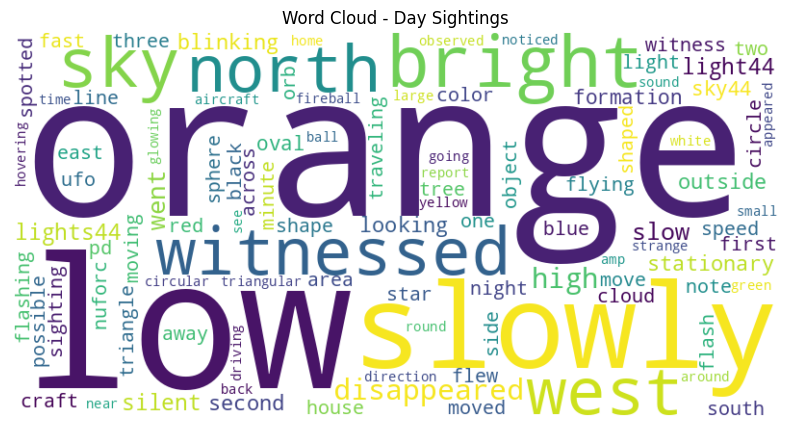

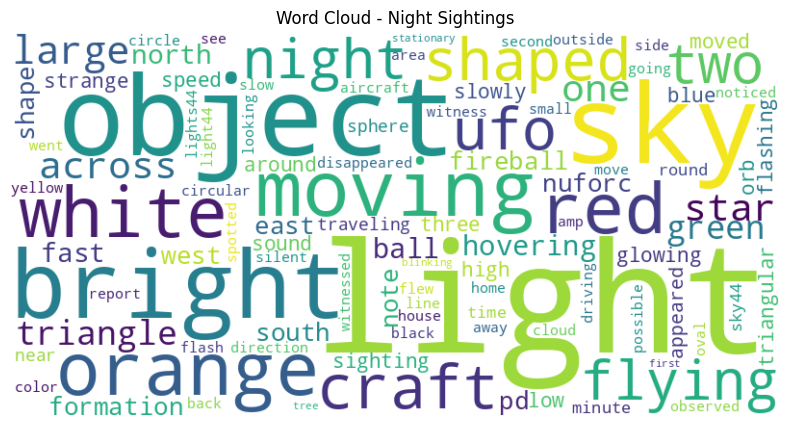

In [ ]:
word_freq_day = dict(zip(
    count_vectorizer.get_feature_names_out(),
    X_countday.toarray().sum(axis=0)
))

word_freq_night = dict(zip(
    count_vectorizer.get_feature_names_out(),
    X_countnight.toarray().sum(axis=0)
))

wc_day = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_day)
plt.figure(figsize=(10, 5))
plt.imshow(wc_day, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Day Sightings")
plt.show()
print("\n\n")
wc_night = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_night)
plt.figure(figsize=(10, 5))
plt.imshow(wc_night, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Night Sightings")
plt.show()

**Relationship between color mentions and UFO Sightings shape**

Textual Patterns and Visual Analysis of UFO Sightings

Steps Taken:

1. Defined a list of color keywords to search for in the text (e.g., "red", "green", "blue", etc.).

2. Filtered the dataset to include only the six most common UFO shapes.

3. For each shape, scanned all associated text descriptions and counted how often each color word appeared. This produced a table showing the absolute frequency of each color per shape.

4. Generated two heatmaps:

  - One showing the absolute number of mentions of each color per shape.

  - Another showing the relative frequency (i.e., what percentage of mentions for each shape involved a specific color).

**Key Observations:**

**Absolute Mentions (Heatmap 1):**
1. The most frequently mentioned colors overall are orange, red, and white.

2. For the shape light, the most common colors mentioned are white, red, and orange, with white being the most frequent.

3. For fireball and circle, orange is the dominant color.

4. The shape light has the highest number of total color mentions among all shapes.

5. The shape triangle also shows a significant count for black, more than most other shapes.


**Relative Mentions (Proportion Heatmap):**
1. 43.2% of all reports mentioning fireball also mention the color orange — by far the strongest color-shape connection in the data.

2. Apart from fireball, white is consistently present in 20% or more of reports across all other shapes — meaning at least 1 in 5 sightings include this color.

3. Although green is not the most frequent color overall, it has a notably high proportion (20%) in fireball reports — suggesting a potential association between green hues and this particular shape.


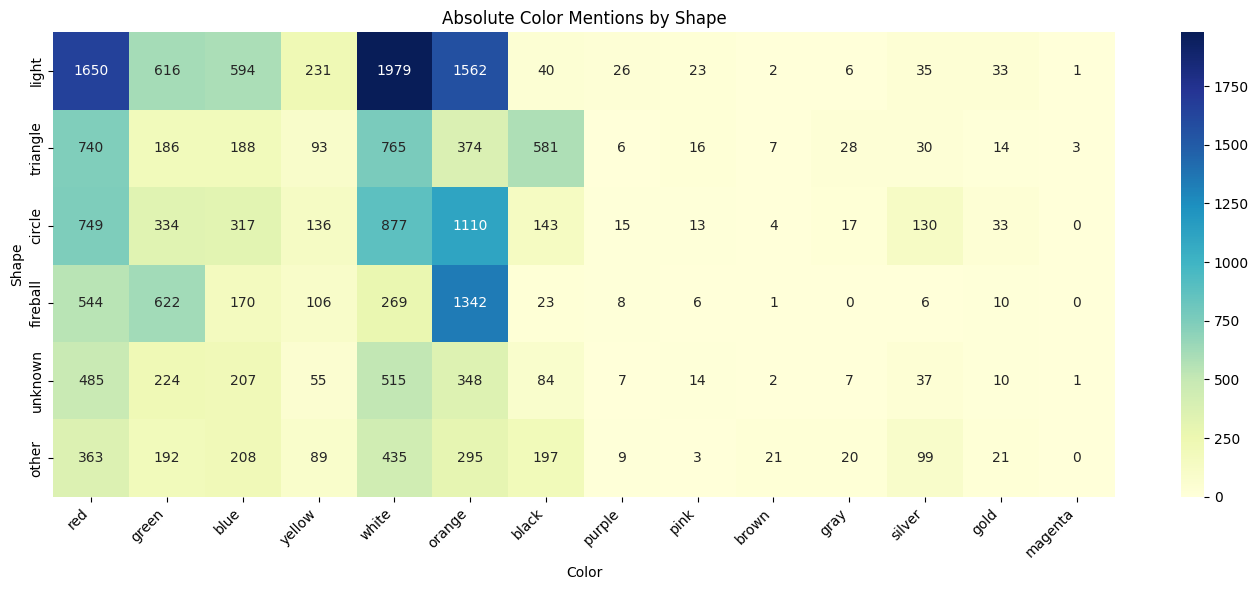

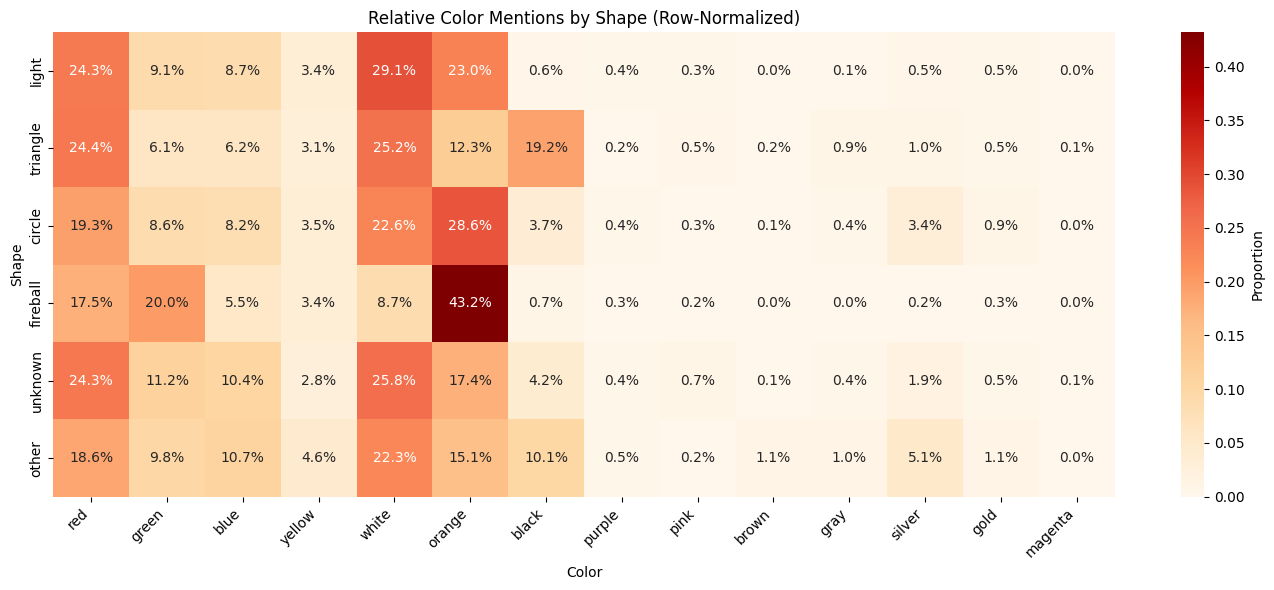

In [ ]:
color_keywords = [
    "red", "green", "blue", "yellow", "white", "orange", "black", "purple",
    "pink", "brown", "gray", "silver", "gold", "magenta"
]

df_filtered = df.dropna(subset=['tokens_str', 'shape_grouped'])

top_shapes = df_filtered['shape_grouped'].value_counts().nlargest(6).index
df_filtered = df_filtered[df_filtered['shape_grouped'].isin(top_shapes)]

heatmap_colors = pd.DataFrame(0, index=top_shapes, columns=color_keywords)

for shape in top_shapes:
    texts = df_filtered[df_filtered['shape_grouped'] == shape]['tokens_str'].astype(str)
    for text in texts:
        word_counts = Counter(text.split())
        for color in color_keywords:
            heatmap_colors.loc[shape, color] += word_counts.get(color, 0)

# Heatmap absolute
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_colors, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Absolute Color Mentions by Shape")
plt.xlabel("Color")
plt.ylabel("Shape")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Heatmap relative
heatmap_relative = heatmap_colors.div(heatmap_colors.sum(axis=1), axis=0)
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_relative, cmap="OrRd", annot=True, fmt=".1%", cbar_kws={'label': 'Proportion'})
plt.title("Relative Color Mentions by Shape (Row-Normalized)")
plt.xlabel("Color")
plt.ylabel("Shape")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Find clusters in usa top 10 states**

Vectorization

This code block generates semantic vector representations (embeddings) for each sighting description using the SentenceTransformer model 'all-MiniLM-L6-v2'.

Each comment is converted into a high-dimensional vector that captures the meaning of the text. This allows us to later group similar sightings based on their semantic content, not just word overlap.

In [ ]:

df_usa = df[(df['country'] == 'us') & df['tokens_str'].notna()].copy()
df_usa = df_usa.reset_index(drop=True)

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_usa['tokens_str'].astype(str), show_progress_bar=True)


Batches:   0%|          | 0/2197 [00:00<?, ?it/s]

NLP algorithms + Visualization

This block performs unsupervised clustering and visualization on the semantic text embeddings:

**Clustering UFO Sightings with KMeans:**

- KMeans(n_clusters=5) is applied to the sentence embeddings to group similar sighting descriptions into 5 clusters, based on semantic similarity (i.e., meaning of the text).

- Each comment is assigned a cluster label in the df_usa DataFrame.

**Cluster Distribution Across States:**

- A cluster-state frequency table is computed to show how many sightings from each state fall into each cluster.

- This table is normalized per state to calculate the percentage of each cluster in the top 10 states with the most sightings.

- A heatmap is plotted to visualize how different clusters are distributed geographically across the top states.

**TF-IDF WordCloud per Cluster**
- For each cluster, the top 100 most informative words are extracted using TF-IDF (Term Frequency–Inverse Document Frequency).

- A WordCloud is generated showing the 30 most important words for that cluster, based on TF-IDF scores.

- These clouds highlight the key themes and vocabulary used in that cluster’s sightings.


**Purpose of the Block:**
1. The goal of this block was to group the sighting comments from the top 10 U.S. states into semantic clusters using KMeans. Each cluster was meant to represent a group of sightings with similar meanings. To achieve this, we used Sentence-BERT to convert each text into an embedded vector, enabling semantic comparisons between descriptions. These vectors were then clustered using KMeans to identify groups of related reports.

2. Cluster Distribution by State:
When we analyzed how the states were distributed across the clusters, we found that the proportions were fairly similar for all states. This suggests that there is no strong regional difference in the types of sightings described — the content of the reports is distributed rather evenly across clusters.

3. Interpretation of Clusters:
From the printed example texts that i print  and the TF-IDF word clouds, it was difficult to clearly characterize the unique meaning of each cluster. Many of the same keywords appeared across clusters with similar frequency, making it hard to differentiate between them in a meaningful way.

Conclusion:
We attempted to uncover differences in the nature of UFO sightings between various U.S. states by clustering them based on semantic content. However, the results suggest that either the clustering did not form clearly distinct groups, or there are no strong textual differences in the way sightings are reported across regions.



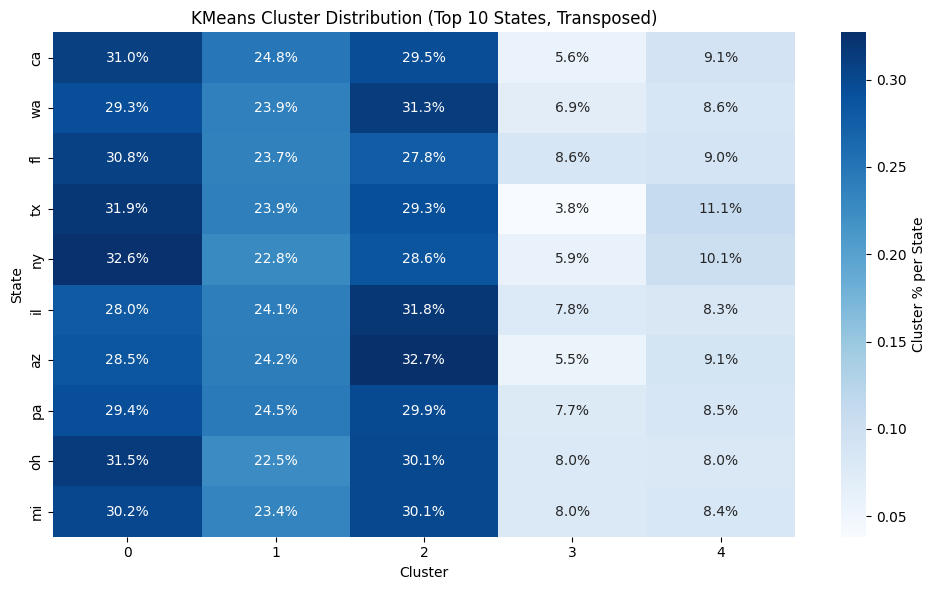

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df_usa['cluster'] = kmeans.fit_predict(embeddings)

cluster_state_counts = df_usa.groupby(['cluster', 'state']).size().unstack(fill_value=0)

cluster_state_props = cluster_state_counts.div(cluster_state_counts.sum(axis=0), axis=1)

top_states = df_usa['state'].value_counts().nlargest(10).index
cluster_state_props_filtered = cluster_state_props[top_states]

cluster_state_props_transposed = cluster_state_props_filtered.T

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_state_props_transposed, cmap="Blues", annot=True, fmt=".1%", cbar_kws={'label': 'Cluster % per State'})
plt.title("KMeans Cluster Distribution (Top 10 States, Transposed)")
plt.xlabel("Cluster")
plt.ylabel("State")
plt.tight_layout()
plt.show()
print("\n\n")

# for cluster_id in range(5):
#     df_cluster = df_usa[df_usa['cluster'] == cluster_id]

#     vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
#     X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
#     word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

#     wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

#     plt.figure(figsize=(10, 5))
#     plt.imshow(wc, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
#     plt.show()
#     print("\n\n")


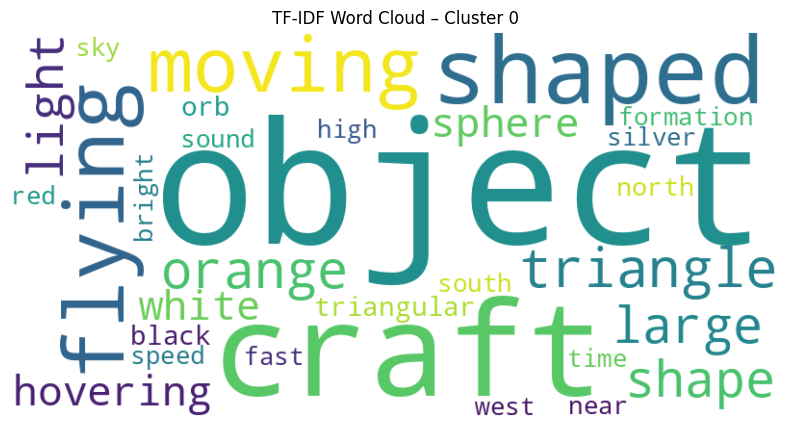

In [ ]:
cluster_id = 0
df_cluster = df_usa[df_usa['cluster'] == cluster_id]

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
plt.show()

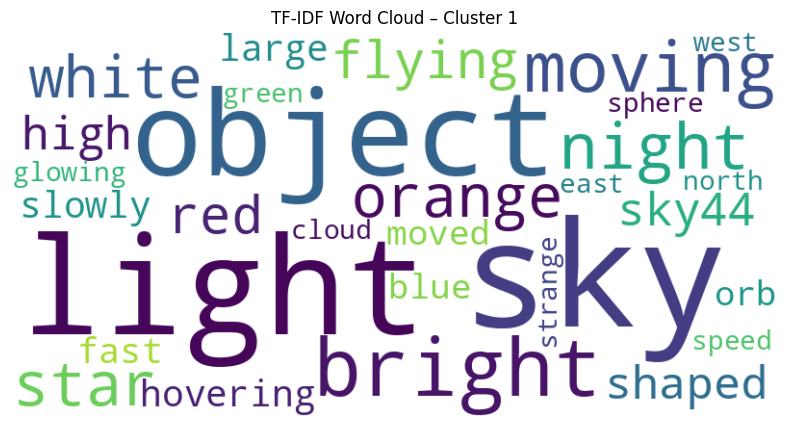

In [ ]:
cluster_id = 1
df_cluster = df_usa[df_usa['cluster'] == cluster_id]

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
plt.show()

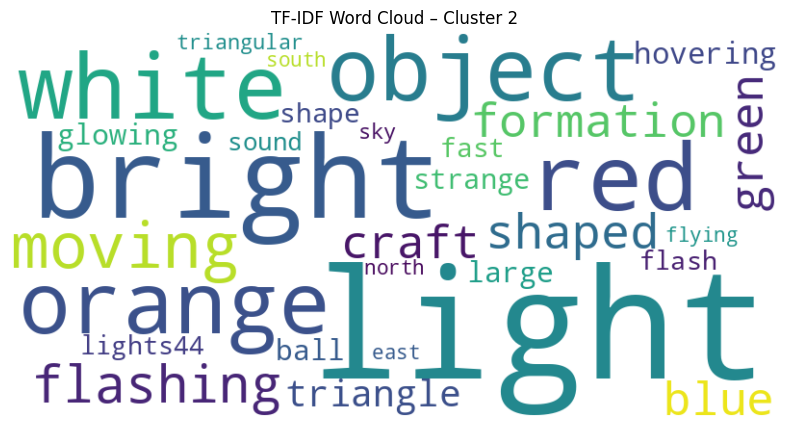

In [ ]:
cluster_id = 2
df_cluster = df_usa[df_usa['cluster'] == cluster_id]

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
plt.show()

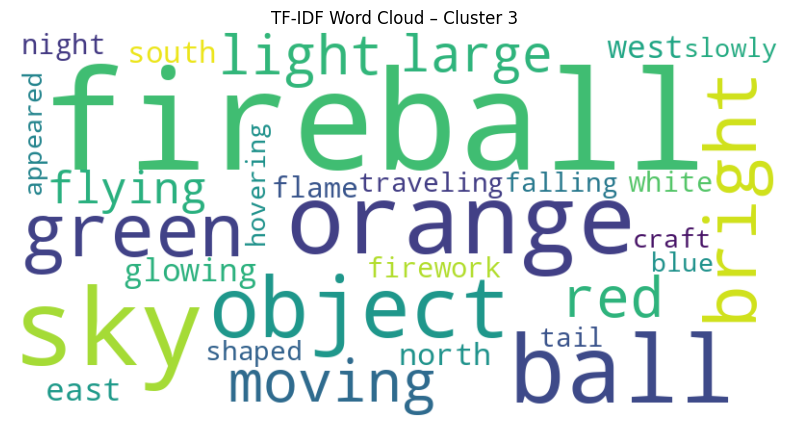

In [ ]:
cluster_id = 3
df_cluster = df_usa[df_usa['cluster'] == cluster_id]

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
plt.show()

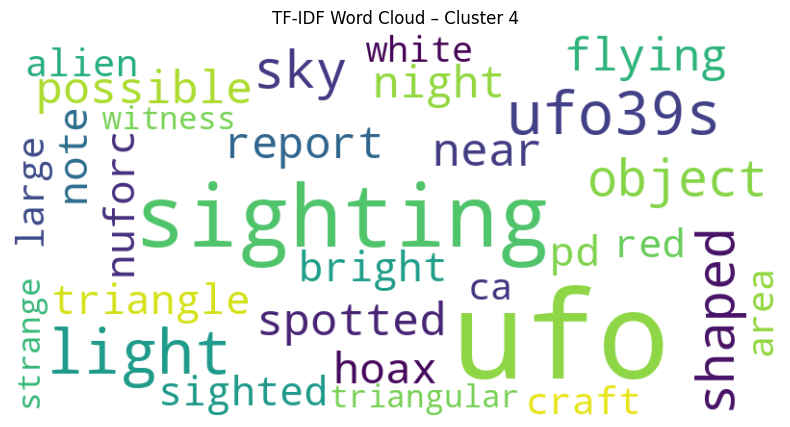

In [ ]:
cluster_id = 4
df_cluster = df_usa[df_usa['cluster'] == cluster_id]

vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df_cluster['tokens_str'].astype(str))
word_tfidf = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

wc = WordCloud(width=800, height=400, background_color='white', max_words=30).generate_from_frequencies(word_tfidf)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title(f"TF-IDF Word Cloud – Cluster {cluster_id}")
plt.show()

In [ ]:
# df_usa = df_usa[df_usa['tokens_str'].notna()].copy()

# for cluster_id in sorted(df_usa['cluster'].unique()):
#     cluster_texts = df_usa[df_usa['cluster'] == cluster_id]['tokens_str'].astype(str).tolist()

#     if len(cluster_texts) < 5:
#         continue

#     print(f"\n=== Cluster {cluster_id} ({len(cluster_texts)} entries) ===")

#     vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
#     X = vectorizer.fit_transform(cluster_texts)
#     top_terms = vectorizer.get_feature_names_out()

#     print("Top TF-IDF Terms:", ', '.join(top_terms))

#     example_texts = df_usa[df_usa['cluster'] == cluster_id]['comments'].dropna().sample(3, random_state=cluster_id)
#     for i, example in enumerate(example_texts, 1):
#         print(f"\nExample {i}:\n{example.strip()}")